We have integrated the TCN-HPL activity classification algorithm into a ROS2 node, but we need to validate that it predicts in a consistent manner as the reference framework from which we have integrated from.

This sketches scoring output of the ROS2 node (`ros/angel_system_nodes/angel_system_nodes/activity_classification/activity_classifier_tcn.py`) by using its "input" mode to provide it object detections.
We choose an set of object detections that have also been run through the reference system so that we have reference activity class predictions as well.

This bases itself on that we have ground-truth and "reference" activity predictions in equivalent MSCOCO format.
We say "reference" to refer to the TCN-HPL repository harness functionality from which we have integrated from.

---

Chosen "bag": `all_activities_20` -- coffee task included in the detection/activity-classification test set.

Detection MSCOCO source from gyges: `/data/PTG/cooking/training/yolo_object_detector/detect/coffee+tea+dq+oatmeal+pinwheel_yolov7/coffee+tea+dq+oatmeal+pinwheel_yolov7_test_obj_results.mscoco.json`

Activity MSCOCO source from gyges: `/data/PTG/cooking/training/activity_classifier/TCN_HPL/logs/yolo_all_recipes/runs/2023-10-24_19-47-09/test_activity_preds.mscoco.json`

Activity MSCOCO file for video `all_activities_20` includes predictions+truth for frame indices 1-29, which we drop as the first predictable frame window (size=30) is on frame 30.

### ROS2 results generation
Run using activity node using input and output MSCOCO options.
Paths to `output_predictions_kwcoco` and `input_obj_det_kwcoco` are arbitrary, i.e. don't *have* to be in `BAGS_DIR` or `MODEL_DIR`, but need to refer to the object detections MSCOCO referenced above.
The output path we will reference below to make use of.
```bash
$ ros2 run angel_system_nodes activity_classifier_tcn --ros-args \
    -r __ns:=${ROS_NAMESPACE} \
    -p image_ts_topic:=PVFramesRGB_TS \
    -p det_topic:=ObjectDetections2d \
    -p act_topic:=ActivityDetections \
    -p model_weights:=${MODEL_DIR}/activity_tcn-all_activities-checkpoint.ckpt \
    -p model_mapping:=${MODEL_DIR}/activity_tcn-all_activities-mapping.txt \
    -p model_det_label_mapping:=${MODEL_DIR}/activity_tcn-all_activities-det_label_mapping.json \
    -p model_device:=cuda:0 \
    -p model_dets_conv_version:=5 \
    -p window_size:=30 \
    -p buffer_max_size_seconds:=5 \
    -p image_pix_width:=1280 \
    -p image_pix_height:=720 \
    -p output_predictions_kwcoco:=${BAGS_DIR}/all_activities_20-activity_tcn_predictions.mscoco.json \
    -p input_obj_det_kwcoco:=${MODEL_DIR}/test-object-detections/coffee+tea+dq+oatmeal+pinwheel_yolov7_test_obj_results-all_activities_20.mscoco.json
```

In [1]:
import kwcoco
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

In [2]:
# Reference COCO file is from gyges and is output from the reference framework, i.e. it is the "golden" output
# that the ROS integration should equivalently output for the same input.
REFERENCE_ACTIVITY_OUTPUT = "/home/local/KHQ/paul.tunison/data/darpa-ptg/adhoc_activity_tcn_eval/model-yolo_all_recipes/test_activity_preds.mscoco.json"

# Predicted 
ROS_PRED_ACTIVITY_OUTPUT = "/home/local/KHQ/paul.tunison/dev/darpa-ptg/angel_system/ros_bags/all_activities_20-activity_tcn_predictions.mscoco.json"

In [3]:
dset_ref_activities = kwcoco.CocoDataset(REFERENCE_ACTIVITY_OUTPUT)
dset_pred_activities = kwcoco.CocoDataset(ROS_PRED_ACTIVITY_OUTPUT)

In [4]:
# all_activities_20 is ID 8, so remove all other videos.
dset_ref_activities.remove_videos(set(dset_ref_activities.videos().ids) - {8})

# This file includes references for frames 1-29, which we want to remove.
dset_ref_activities.remove_images(
    [i for i, fi in dset_ref_activities.images().get("frame_index", keepid=True).items() if fi < 30]
)

{'annotations': None, 'images': 29}

In [5]:
dset_ref_activities

<CocoDataset(tag=test_activity_preds.mscoco.json, n_anns=0, n_imgs=12843, n_videos=1, n_cats=0) at 0x7f870859d460>

In [6]:
dset_pred_activities

<CocoDataset(tag=all_activities_20-activity_tcn_predictions.mscoco.json, n_anns=0, n_imgs=12843, n_videos=1, n_cats=0) at 0x7f870859de50>

# Extract Predictions Data

In [7]:
act_label_vec = [
    l for _, l in sorted((int(i), l) for i, l in dset_ref_activities.dataset['info'][0]['activity_labels'].items())
]
num_act_classes = len(act_label_vec)

In [8]:
act_gt = dset_ref_activities.images().get('activity_gt')
gt_onehot_conf = np.zeros((len(act_gt), num_act_classes))
gt_onehot_conf[np.arange(len(act_gt)), act_gt] = 1

act_ref_fidx = dset_ref_activities.images().get("frame_index")
act_ref_pred = dset_ref_activities.images().get("activity_pred")
act_ref_conf = np.asarray(dset_ref_activities.images().get("activity_conf"))

act_pred_fidx = dset_pred_activities.images().get("frame_index")
act_pred_pred = dset_pred_activities.images().get("activity_pred")
act_pred_conf = np.asarray(dset_pred_activities.images().get("activity_conf"))

In [9]:
act_gt_lbls = [act_label_vec[y] for y in act_gt]
act_ref_pred_lbls = [act_label_vec[y] for y in act_ref_pred]
act_pred_pred_lbls = [act_label_vec[y] for y in act_pred_pred]

In [10]:
act_ref_fidx == act_pred_fidx

True

# Reference Results

''

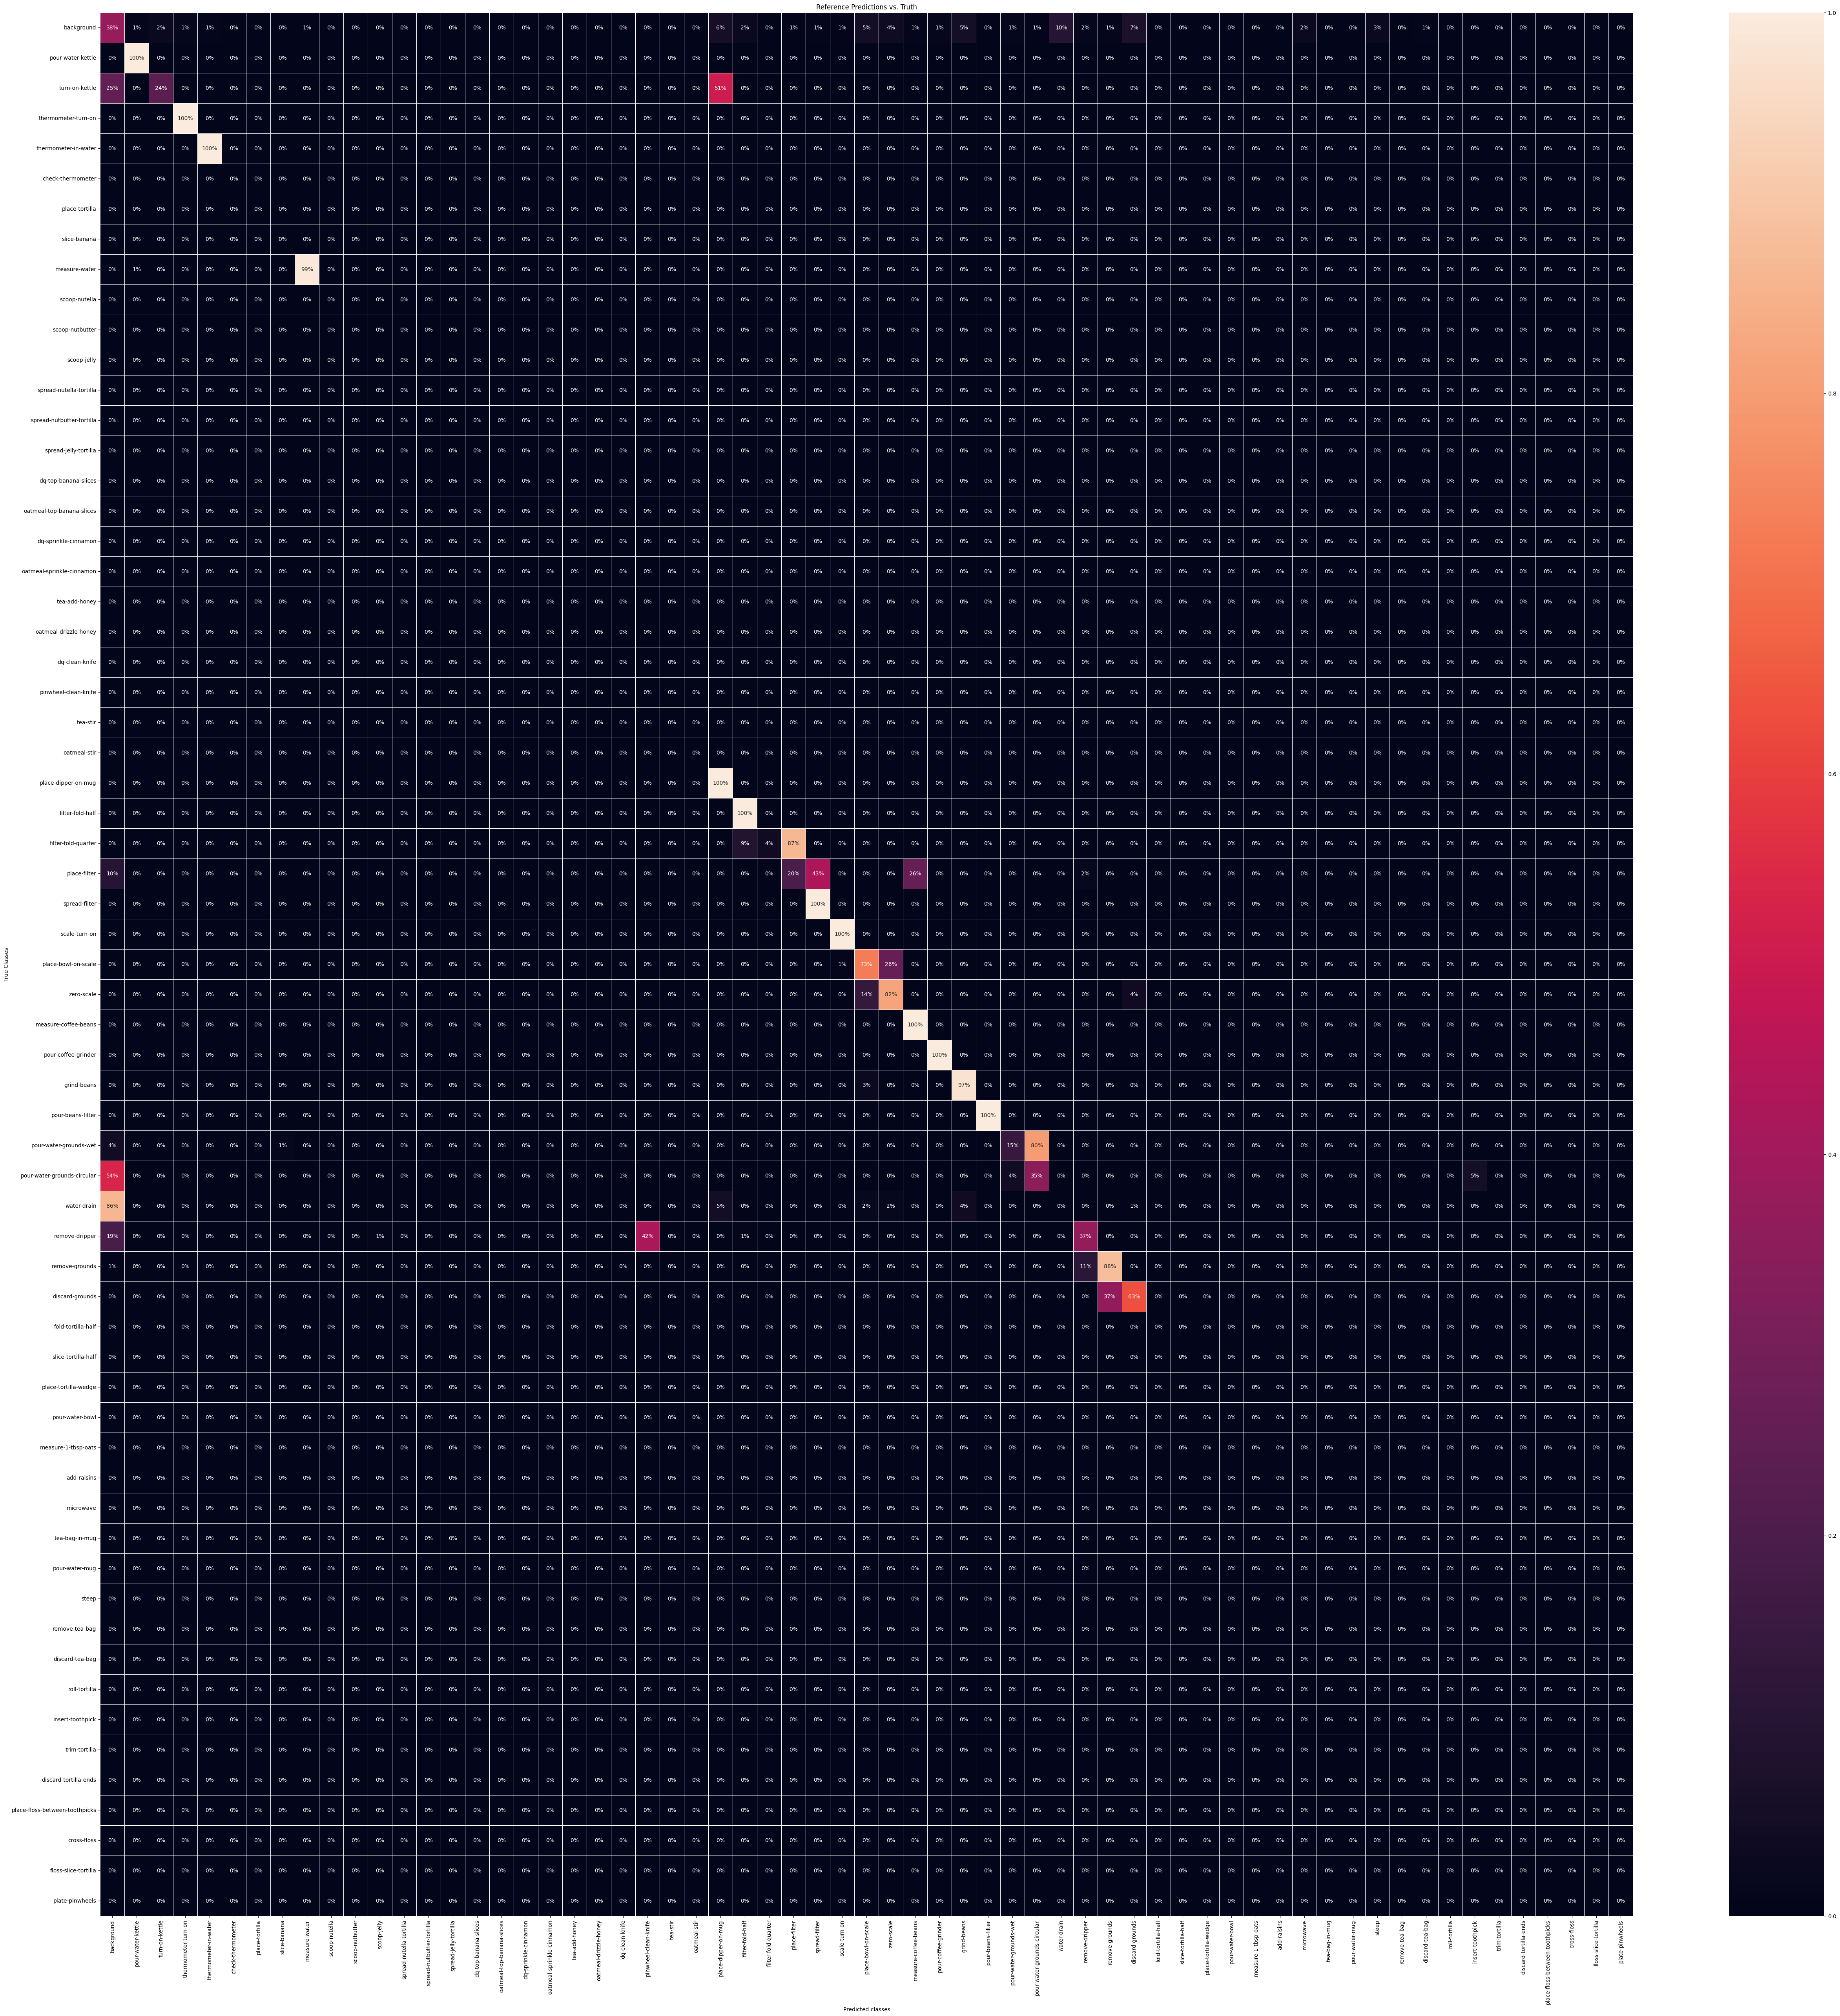

In [11]:
ref_cm = confusion_matrix(act_gt_lbls, act_ref_pred_lbls, labels=act_label_vec, normalize="true")
ref_fig, ref_ax = plt.subplots(figsize=(num_act_classes, num_act_classes))
sns.heatmap(ref_cm, annot=True, ax=ref_ax, fmt="0.0%", linewidth=0.5, vmin=0, vmax=1)
ref_ax.set_xlabel("Predicted classes")
ref_ax.set_ylabel("True Classes")
ref_ax.set_title("Reference Predictions vs. Truth")
ref_ax.xaxis.set_ticklabels(act_label_vec, rotation=90)
ref_ax.yaxis.set_ticklabels(act_label_vec, rotation=0)
""

Text(0.5, 1.0, 'Reverence classifications OvR Multi-class')

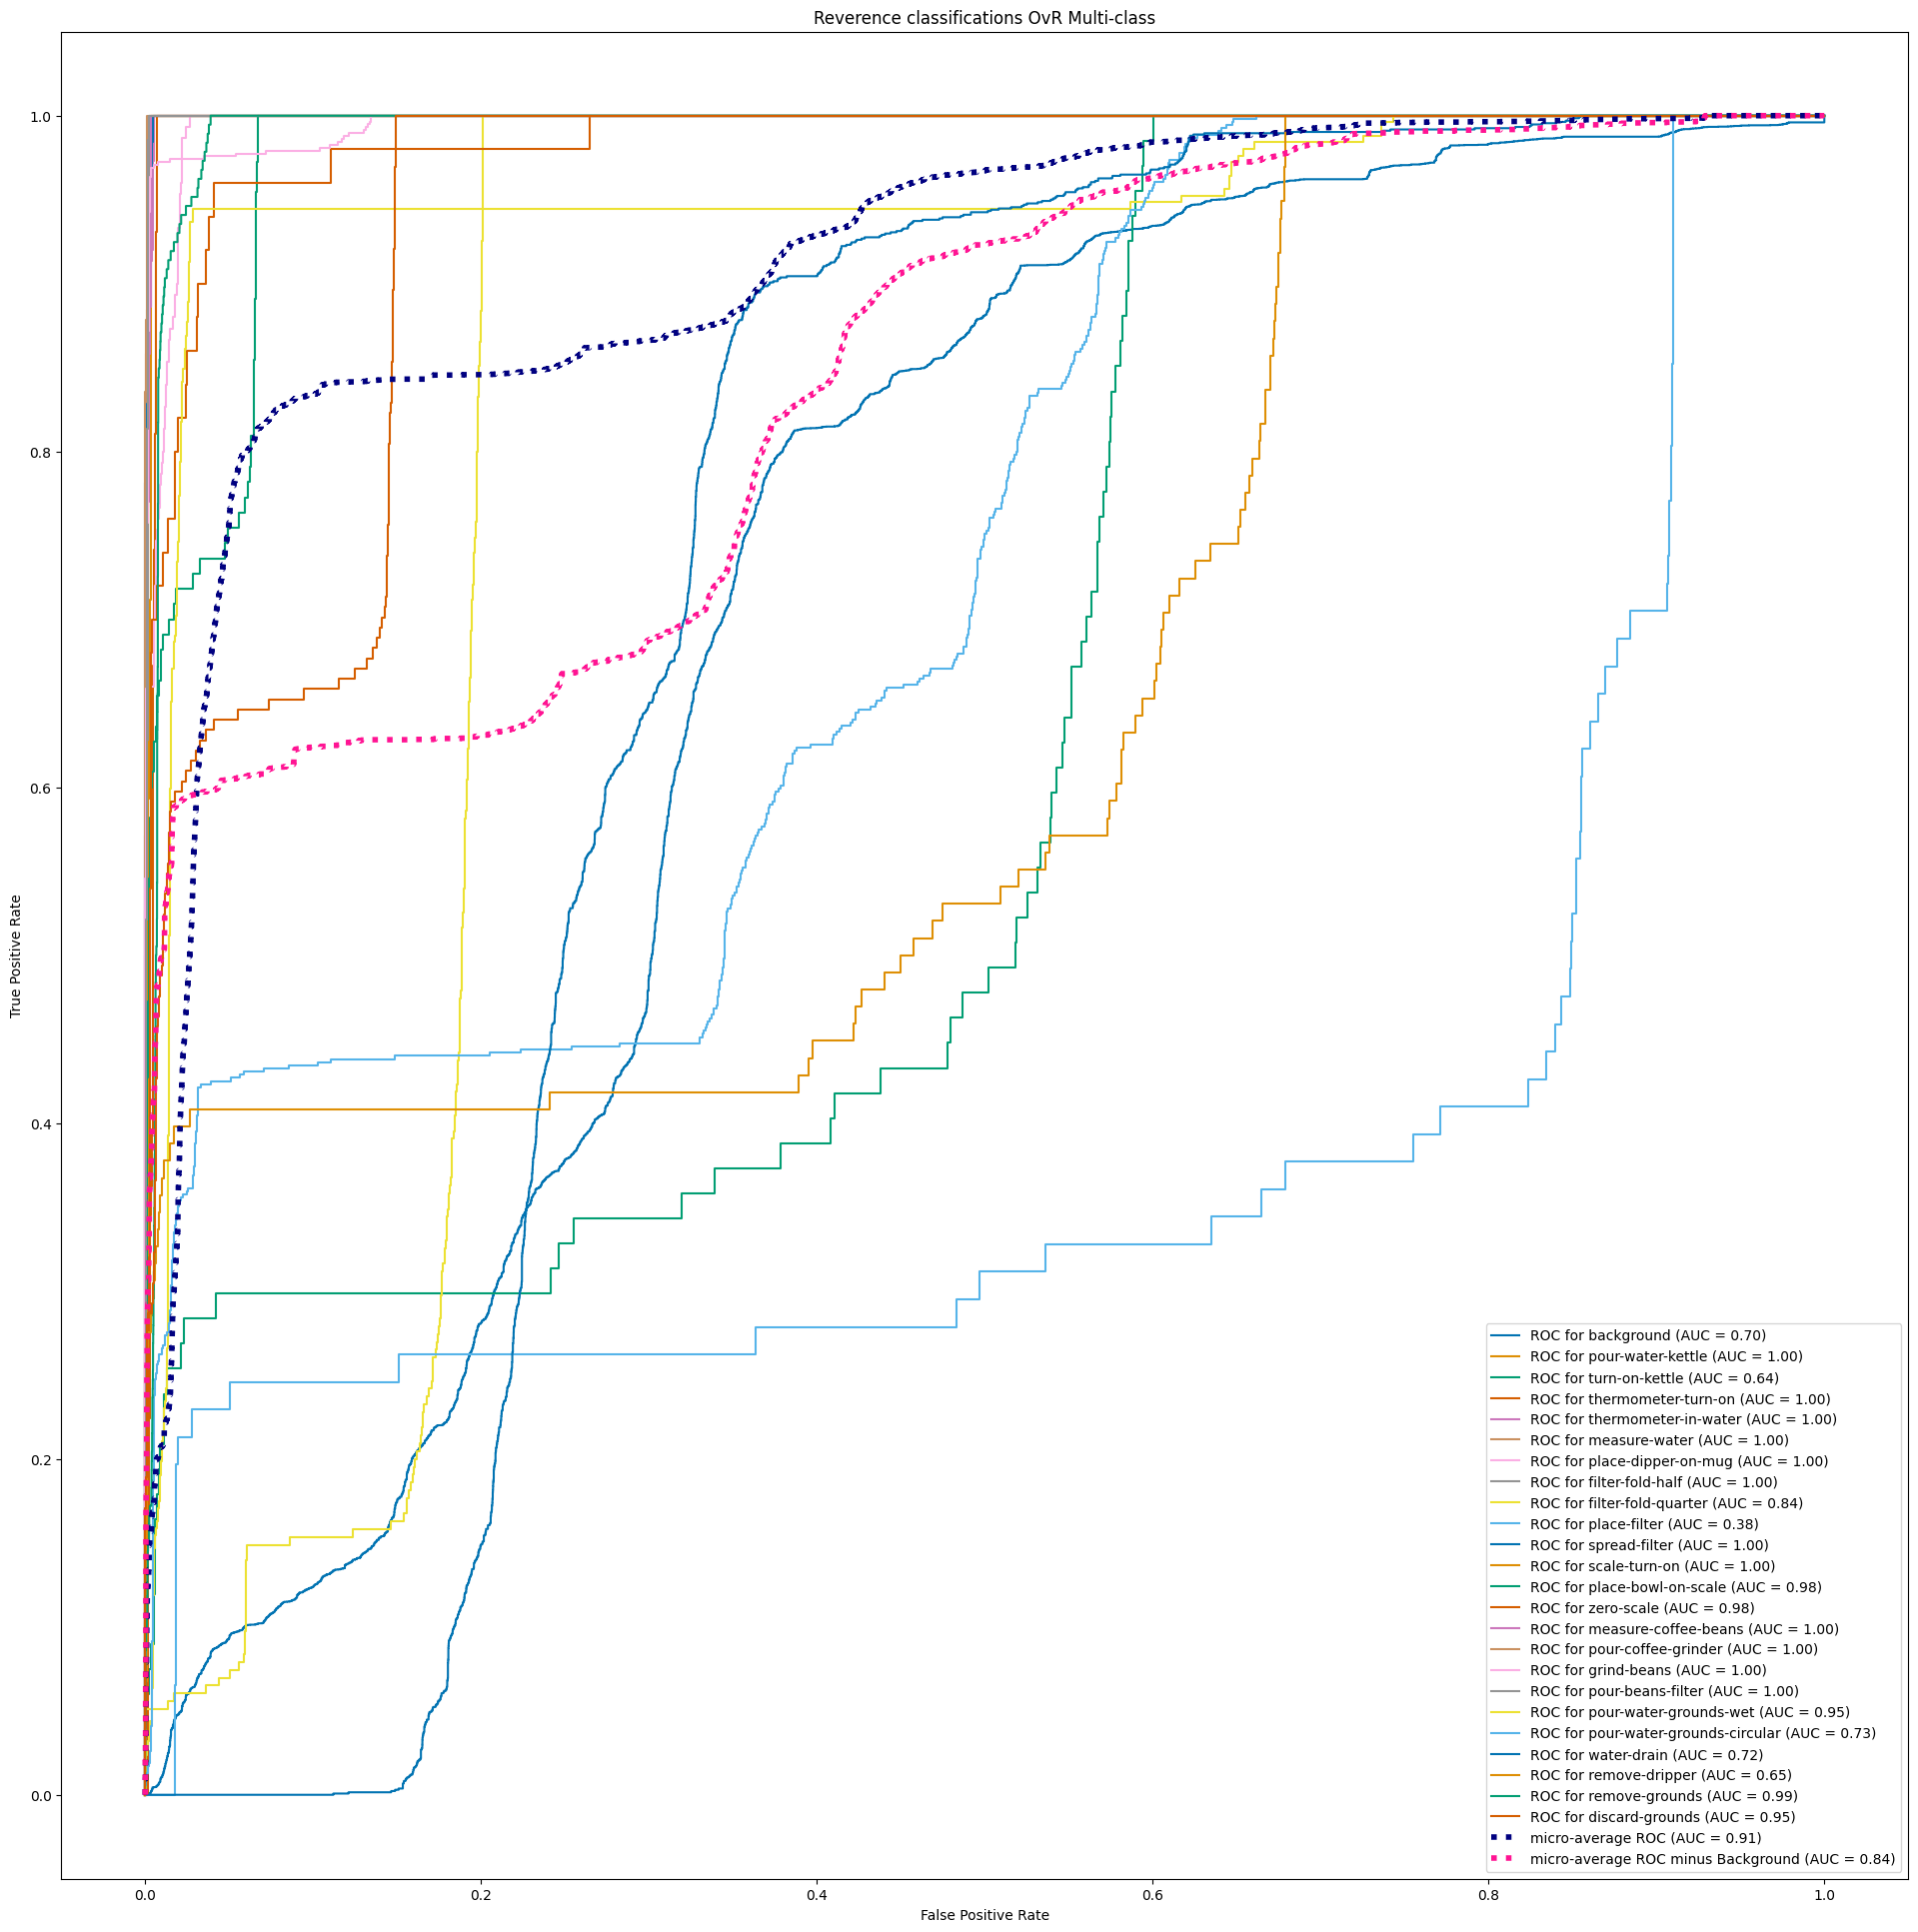

In [12]:
# only some classes are relevant for this pass - union of unique IDs from gt + pred
relevant_act_ids = sorted(set(act_gt))  # and set(act_ref_pred))
n_relevant_acts = len(relevant_act_ids)
# palette = sns.color_palette('husl', n_relevant_acts)
palette = sns.color_palette('colorblind', n_relevant_acts)

fig, ax = plt.subplots(figsize=(n_relevant_acts, n_relevant_acts))

for a_id, color in zip(relevant_act_ids, palette):
    RocCurveDisplay.from_predictions(
        gt_onehot_conf[:, a_id],
        act_ref_conf[:, a_id],
        name=f"ROC for {act_label_vec[a_id]}",
        color=color,
        ax=ax,
    )

# OvR Micro-averages -- not sure if useful here?
RocCurveDisplay.from_predictions(
    gt_onehot_conf[:, relevant_act_ids].ravel(),
    act_ref_conf[:, relevant_act_ids].ravel(),
    name="micro-average ROC",
    color="navy",
    linestyle=":",
    linewidth=4,
    ax=ax,
)

RocCurveDisplay.from_predictions(
    gt_onehot_conf[:, sorted(set(act_gt) - {0})].ravel(),
    act_ref_conf[:, sorted(set(act_gt) - {0})].ravel(),
    name="micro-average ROC minus Background",
    color="deeppink",
    linestyle=":",
    linewidth=4,
    ax=ax,
)

ax.axis("square")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Reverence classifications OvR Multi-class")

# ROS Results

''

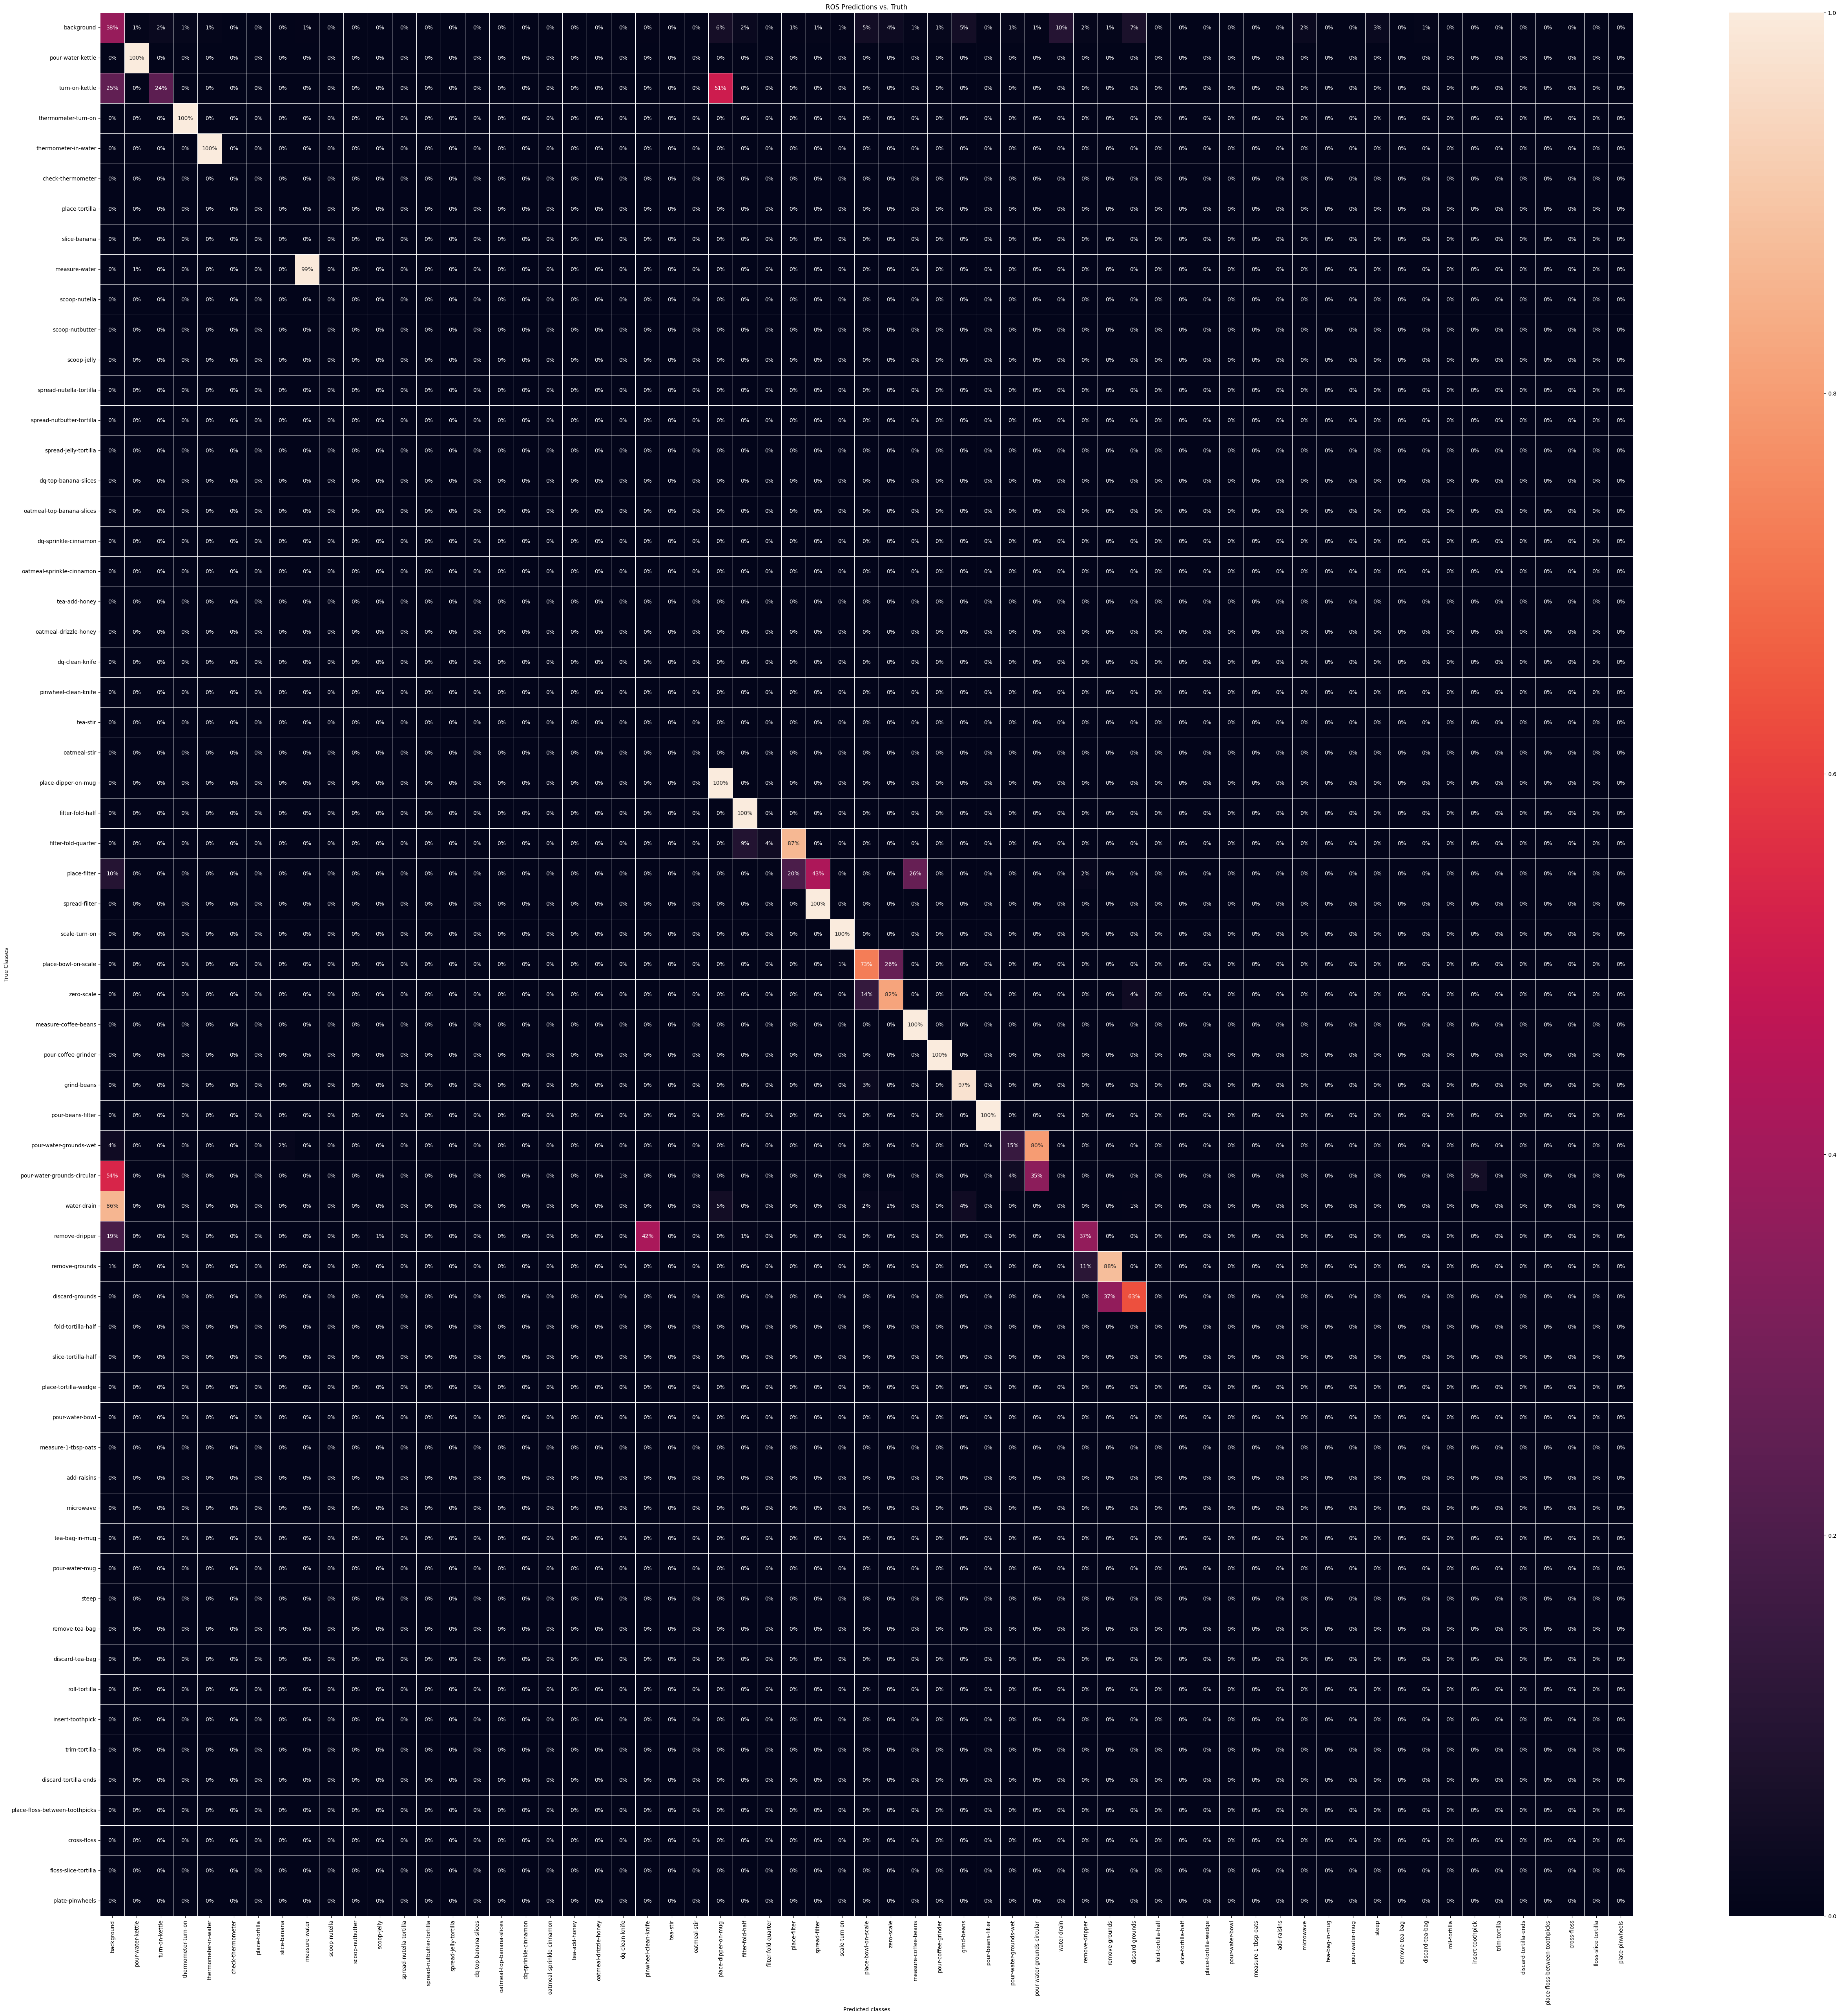

In [13]:
pred_cm = confusion_matrix(act_gt_lbls, act_pred_pred_lbls, labels=act_label_vec, normalize="true")
pred_fig, pred_ax = plt.subplots(figsize=(num_act_classes, num_act_classes))
sns.heatmap(pred_cm, annot=True, ax=pred_ax, fmt="0.0%", linewidth=0.5, vmin=0, vmax=1)
pred_ax.set_xlabel("Predicted classes")
pred_ax.set_ylabel("True Classes")
pred_ax.set_title("ROS Predictions vs. Truth")
pred_ax.xaxis.set_ticklabels(act_label_vec, rotation=90)
pred_ax.yaxis.set_ticklabels(act_label_vec, rotation=0)
''

Text(0.5, 1.0, 'ROS Node classifications OvR Multi-class')

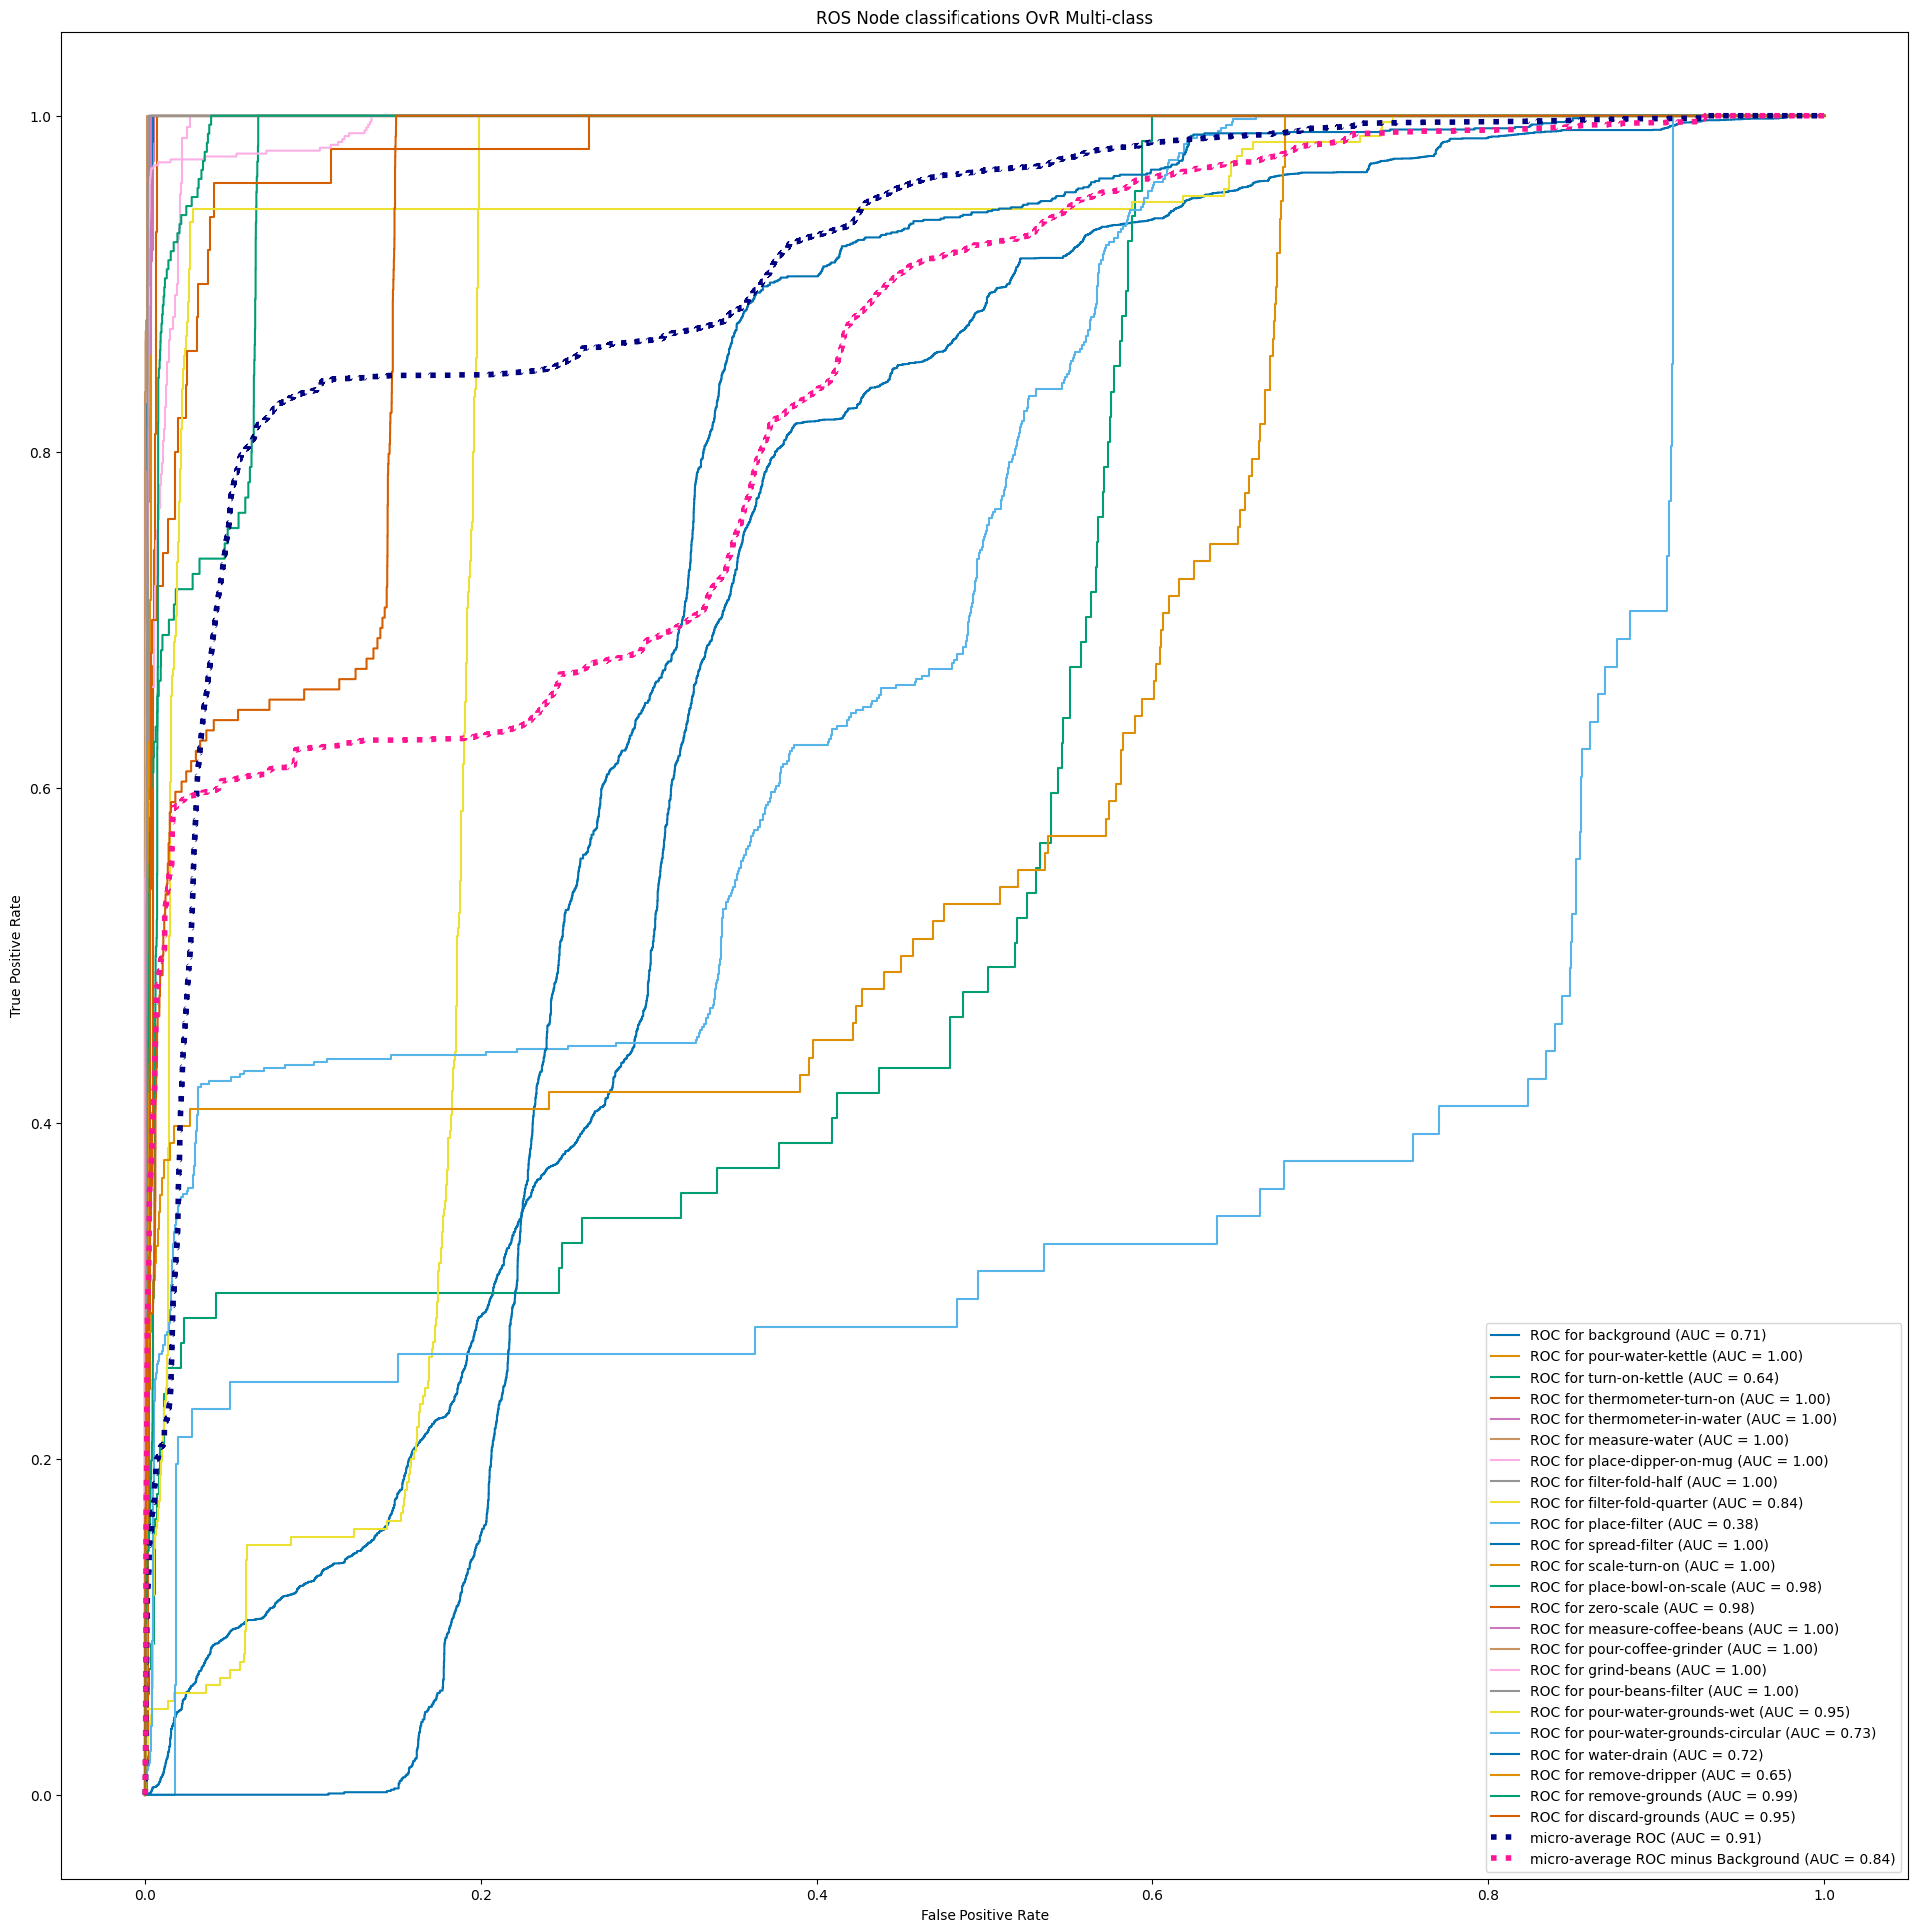

In [14]:
# only some classes are relevant for this pass - union of unique IDs from gt + pred
relevant_act_ids = sorted(set(act_gt))  # and set(act_pred_pred))
n_relevant_acts = len(relevant_act_ids)
palette = sns.color_palette('colorblind', n_relevant_acts)

fig, ax = plt.subplots(figsize=(n_relevant_acts, n_relevant_acts))

for a_id, color in zip(relevant_act_ids, palette):
    RocCurveDisplay.from_predictions(
        gt_onehot_conf[:, a_id],
        act_pred_conf[:, a_id],
        name=f"ROC for {act_label_vec[a_id]}",
        color=color,
        ax=ax,
    )

# OvR Micro-averages -- not sure if useful here?
RocCurveDisplay.from_predictions(
    gt_onehot_conf[:, relevant_act_ids].ravel(),
    act_pred_conf[:, relevant_act_ids].ravel(),
    name="micro-average ROC",
    color="navy",
    linestyle=":",
    linewidth=4,
    ax=ax,
)

RocCurveDisplay.from_predictions(
    gt_onehot_conf[:, sorted(set(act_gt) - {0})].ravel(),
    act_pred_conf[:, sorted(set(act_gt) - {0})].ravel(),
    name="micro-average ROC minus Background",
    color="deeppink",
    linestyle=":",
    linewidth=4,
    ax=ax,
)

ax.axis("square")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROS Node classifications OvR Multi-class")

# Comparisons

''

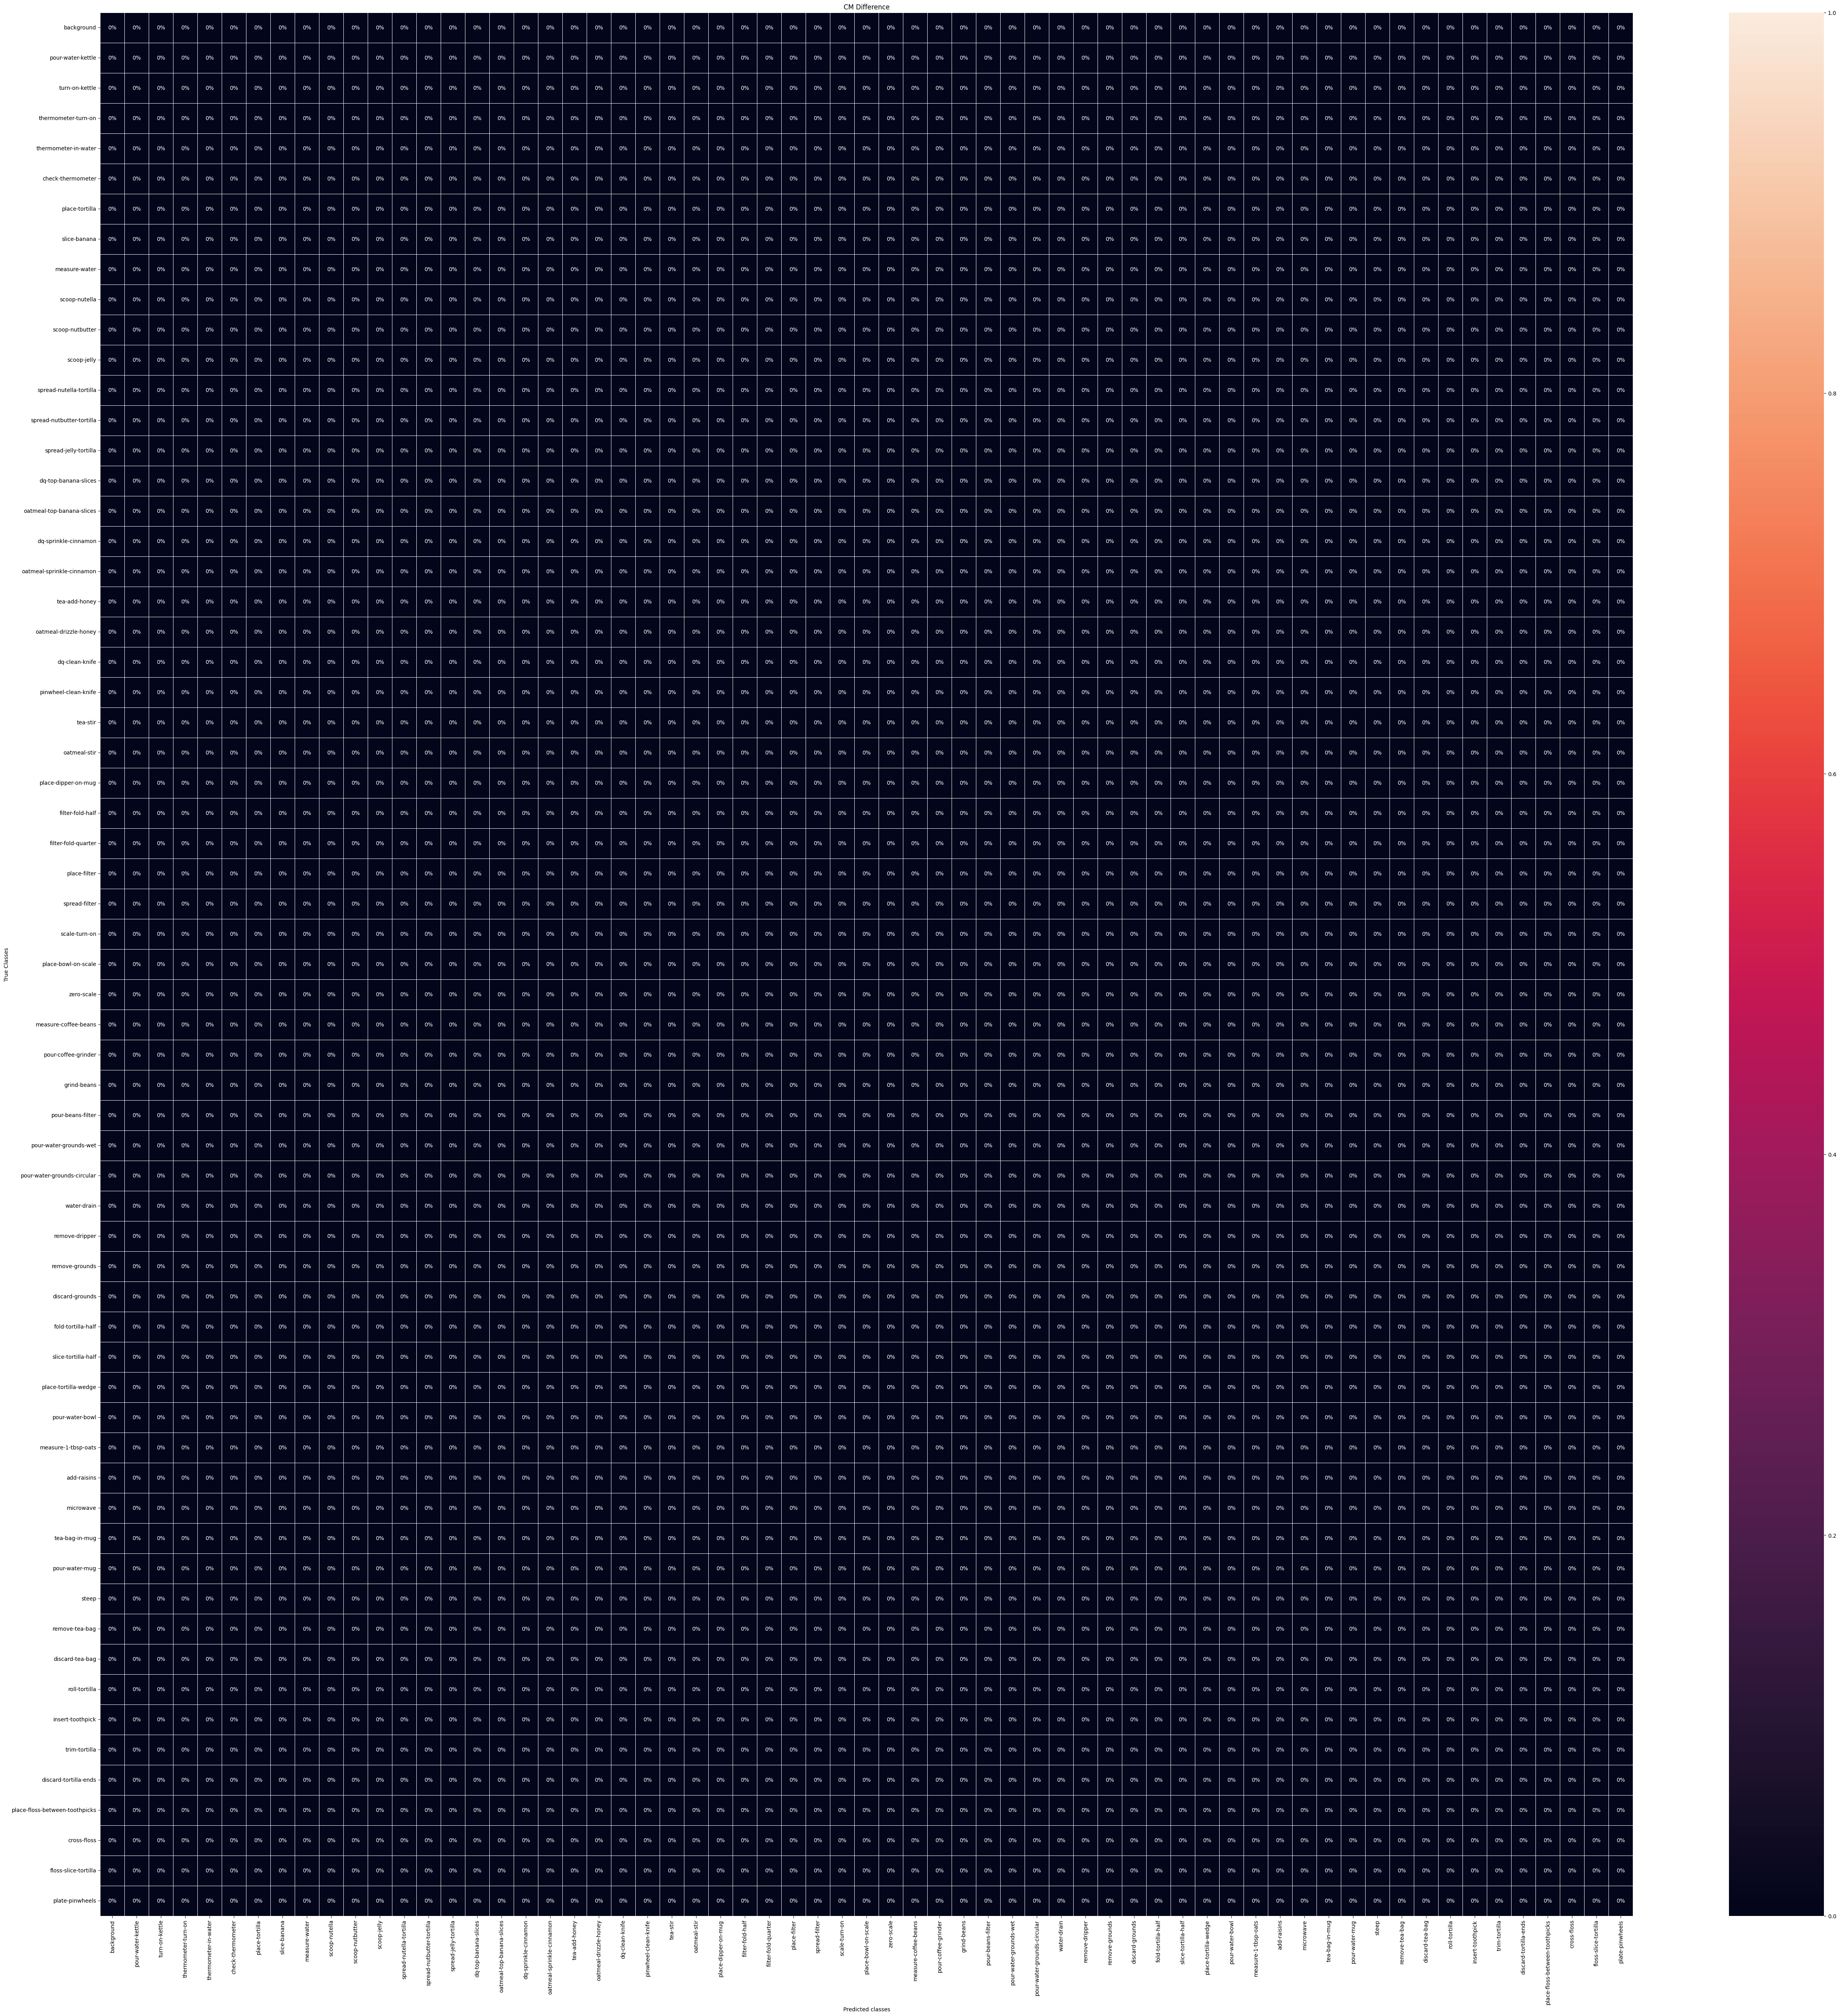

In [15]:
diff_fig, diff_ax = plt.subplots(figsize=(num_act_classes, num_act_classes))
sns.heatmap(
    np.abs(ref_cm - pred_cm), 
    annot=True, ax=diff_ax, fmt="0.0%", linewidth=0.5, vmin=0, vmax=1
)
diff_ax.set_xlabel("Predicted classes")
diff_ax.set_ylabel("True Classes")
diff_ax.set_title("CM Difference")
diff_ax.xaxis.set_ticklabels(act_label_vec, rotation=90)
diff_ax.yaxis.set_ticklabels(act_label_vec, rotation=0)
""

# Scratch